# Ch6. RNN

## 6.1 순환 신경망의 발달 과정

CNN보다 먼저 나옴. 1982년 대중화되었지만 이전에도 언급된 적 있음

LSTM (Long Short-Term Memory), GRU ( Gated Recurrent Unit) 같은 변형 모델이 많이 쓰임

순서 (Sequence) 가 의미 있는 데이터, 시계열(Time seris) 데이터 등에 필요

## 6.2 순환 신경망의 작동 원리

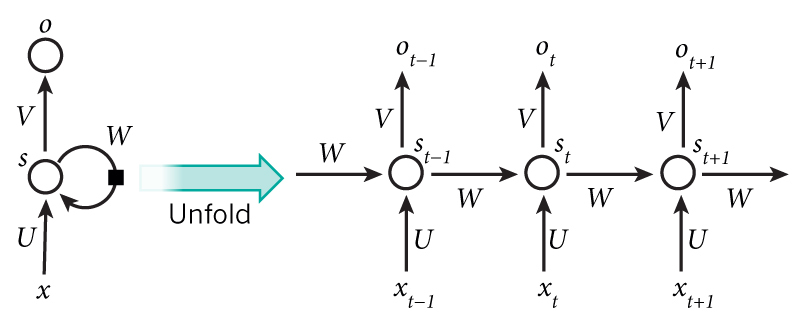

(http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/)

time = t 일때 t= 0, 1, $\cdots$ , t-1 까지 weight에 따라 쓰임 : BPTT (BackPropagation Through Time, 시간에 따른 역전파)를 통해 계산

학습을 하기 위해서는? 손실을 입력과 은닉층들 사이의 가중치로 미분하여 손실에 대한 각각의 비중을 업데이트해야하는데 결과적으로 t=0 시점의 노드 값들에도 영향을 줘야함

입력층 i, 은닉층 h1, h2, 출력 o, 활성화 함수 tanh 라면

\begin{equation}
o = w_{ho} \times h2_{out} + bias \\
h2_{out} = \tanh ( w_{12} \times h1 + w_{22} \times h2_{t=1} + bias ) \\
h1_{out} = \tanh ( w_{ih} \times i + w_{11} \times h1_{t=1} + bias ) \\
h2_{in} = w_{12} \times h1 + w_{22} \times h2_{t=1} + bias \\
h1_{in} = w_{ih} \times h1 + w_{11} \times h1_{t=1} + bias \\
\frac{\partial o}{\partial w_{22}} = \frac{\partial o}{\partial h2_{out}} \times \frac{\partial h2_{out}}{\partial h2_{in}} \times \frac{\partial h2_{in}}{\partial w_{22}}
\end{equation}

## 6.3 모델 구현, 학습 및 결과 확인

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [24]:
n_hidden = 35
learning_rate = 0.01
epoch = 1000

string = "hello pytorch. deeper neural networks are more difficult to train. we present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. we explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. we provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. on the imagenet dataset we evaluate residual nets with a depth of up to 152 layers8 times deeper than vgg nets but still having lower complexity. an ensemble of these residual nets achieves 3.57 percent error on the imagenet test set. this result won the 1st place on the ilsvrc 2015 classification task. we also present analysis on cifar10 with 100 and 1000 layers."
chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;-0123456789@@"
char_list = [i for i in chars]
n_letters = len(char_list)

In [19]:
def string_to_onehot(string): # start, end, 각 char별로 onehot encoding
    start = np.zeros(shape=len(char_list),dtype=int)
    end = np.zeros(shape=len(char_list),dtype=int)
    start[-2]=1
    end[-1] = 1
    for i in string :
        idx = char_list.index(i)
        zero = np.zeros(shape=n_letters, dtype=int)
        zero[idx]=1
        start = np.vstack([start,zero])
    output = np.vstack([start,end])
    return output

In [4]:
def onehot_to_word(onehot_1): # decoding
    onehot = torch.Tensor.numpy(onehot_1)
    return char_list[onehot.argmax()]

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.act_fn = nn.Tanh()
        
    def forward(self, input, hidden): #forward에서 hidden layer에서 인풋에서 넘어온거 + 히든에서 히든으로 가는거 로 activate
        hidden = self.act_fn(self.i2h(input)+self.h2h(hidden))
        output = self.i2o(hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    
rnn = RNN(n_letters, n_hidden, n_letters)

In [9]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

#여기까지 모델정의

In [38]:
#학습해보자

one_hot = torch.from_numpy(string_to_onehot(string)).type_as(torch.FloatTensor())

for i in range(int(epoch/100)):
    rnn.zero_grad()
    total_loss = 0
    hidden = rnn.init_hidden()
    
    for j in range(one_hot.size()[0]-1):
        input_ = one_hot[j:j+1,:]
        target = one_hot[j+1]
        
        output,hidden = rnn.forward(input_,hidden)
        loss = loss_func(output.view(-1),target.view(-1))
        total_loss += loss
        input_ = output
        
    total_loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(i,"th iteration : ",total_loss)

0 th iteration :  tensor(10.4201, grad_fn=<AddBackward0>)


In [39]:
start = torch.zeros(1,len(char_list))
start[:-2]=1


with torch.no_grad():
    hidden = rnn.init_hidden()
    input_ = start
    output_string = ""
    for i in range(len(string)):
        output, hidden = rnn.forward(input_, hidden)
        output_string += onehot_to_word(output.data)
        input_ = output
        
print(output_string)

eeeera  a tia      a                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       


### 6.4 순환 신경망의 한계 및 개선 방안

역전파 시 tanh의 미분값이 여러번 곱해지는데 0 ~ 1 사이값이 나오기 때문에 타임 시퀸스가 길어지면 제대로 학습하지 못하는 경우가 있음 : Vanishing gradient 기울기 소실

활성화 함수를 바꿀 수도 있지만 LSTM이나 GRU

#### LSTM
: Long Shot Term Memory 기존 rnn에서 장기기억에 해당하는 cell state의 전달부분이 추가된 것.

(http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

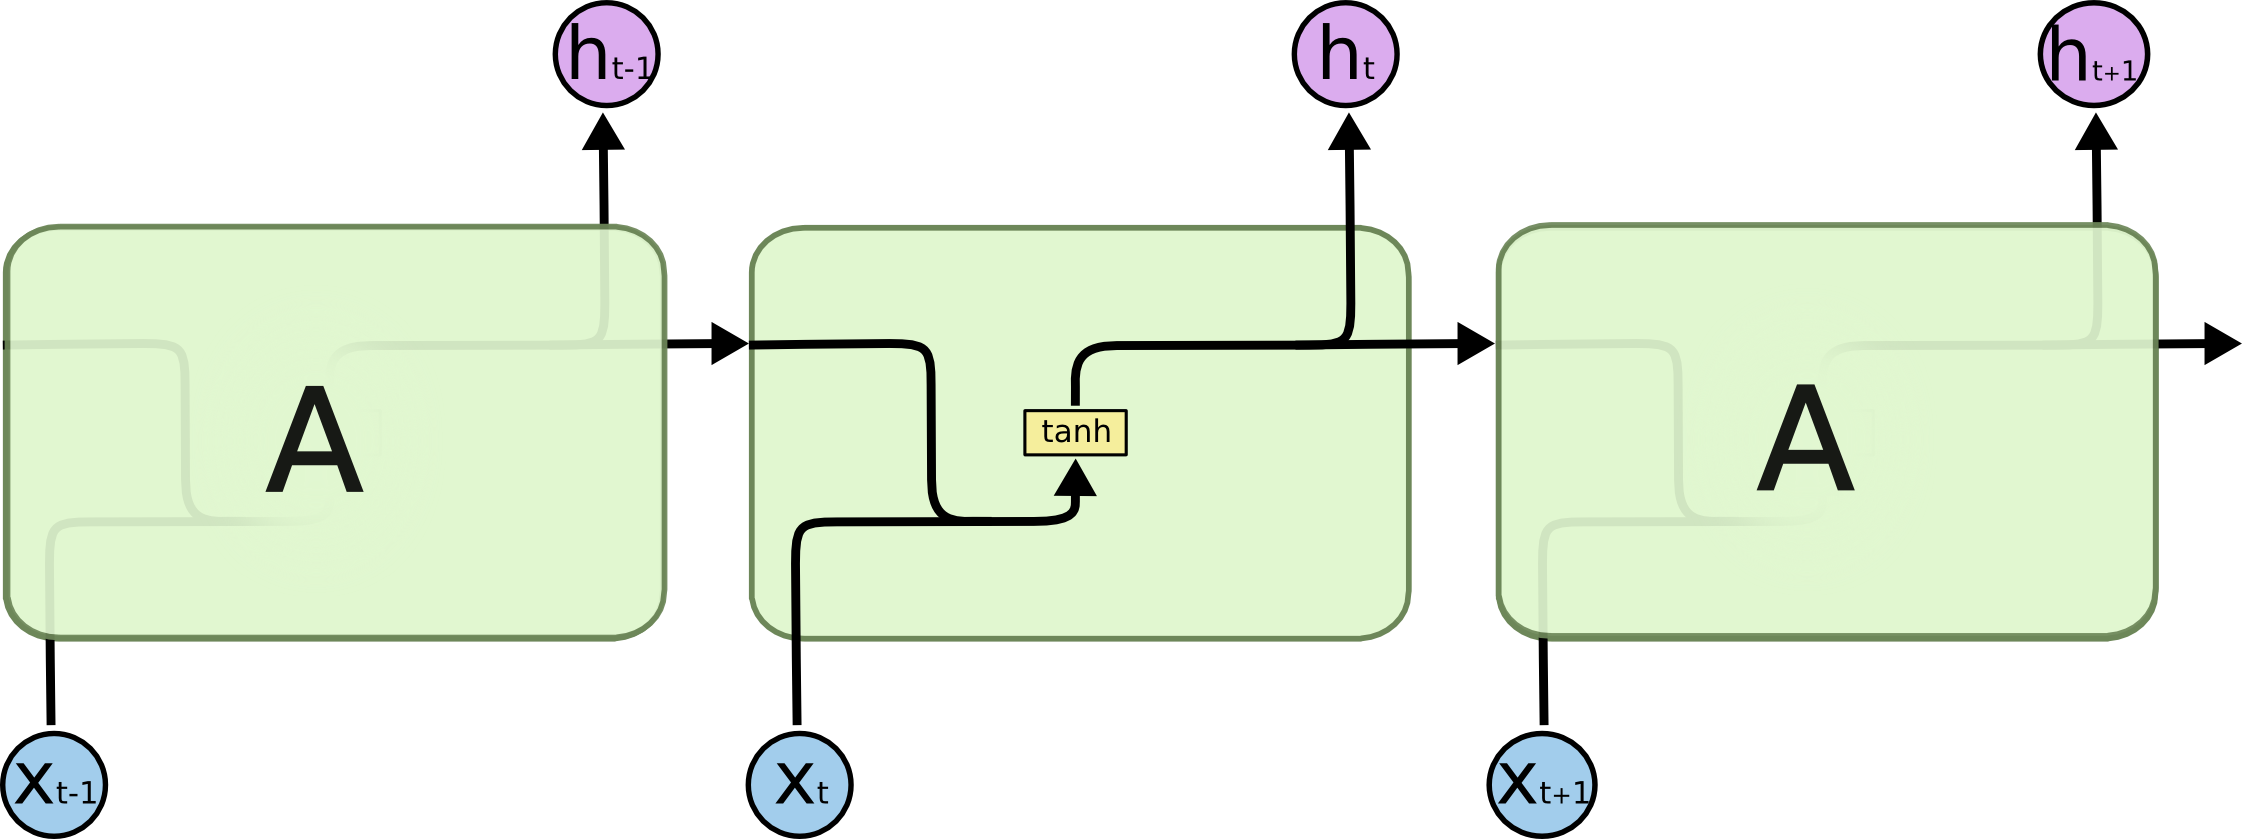

기존 single layer RNN이 위와 같다면 LSTM은 아래와 같음

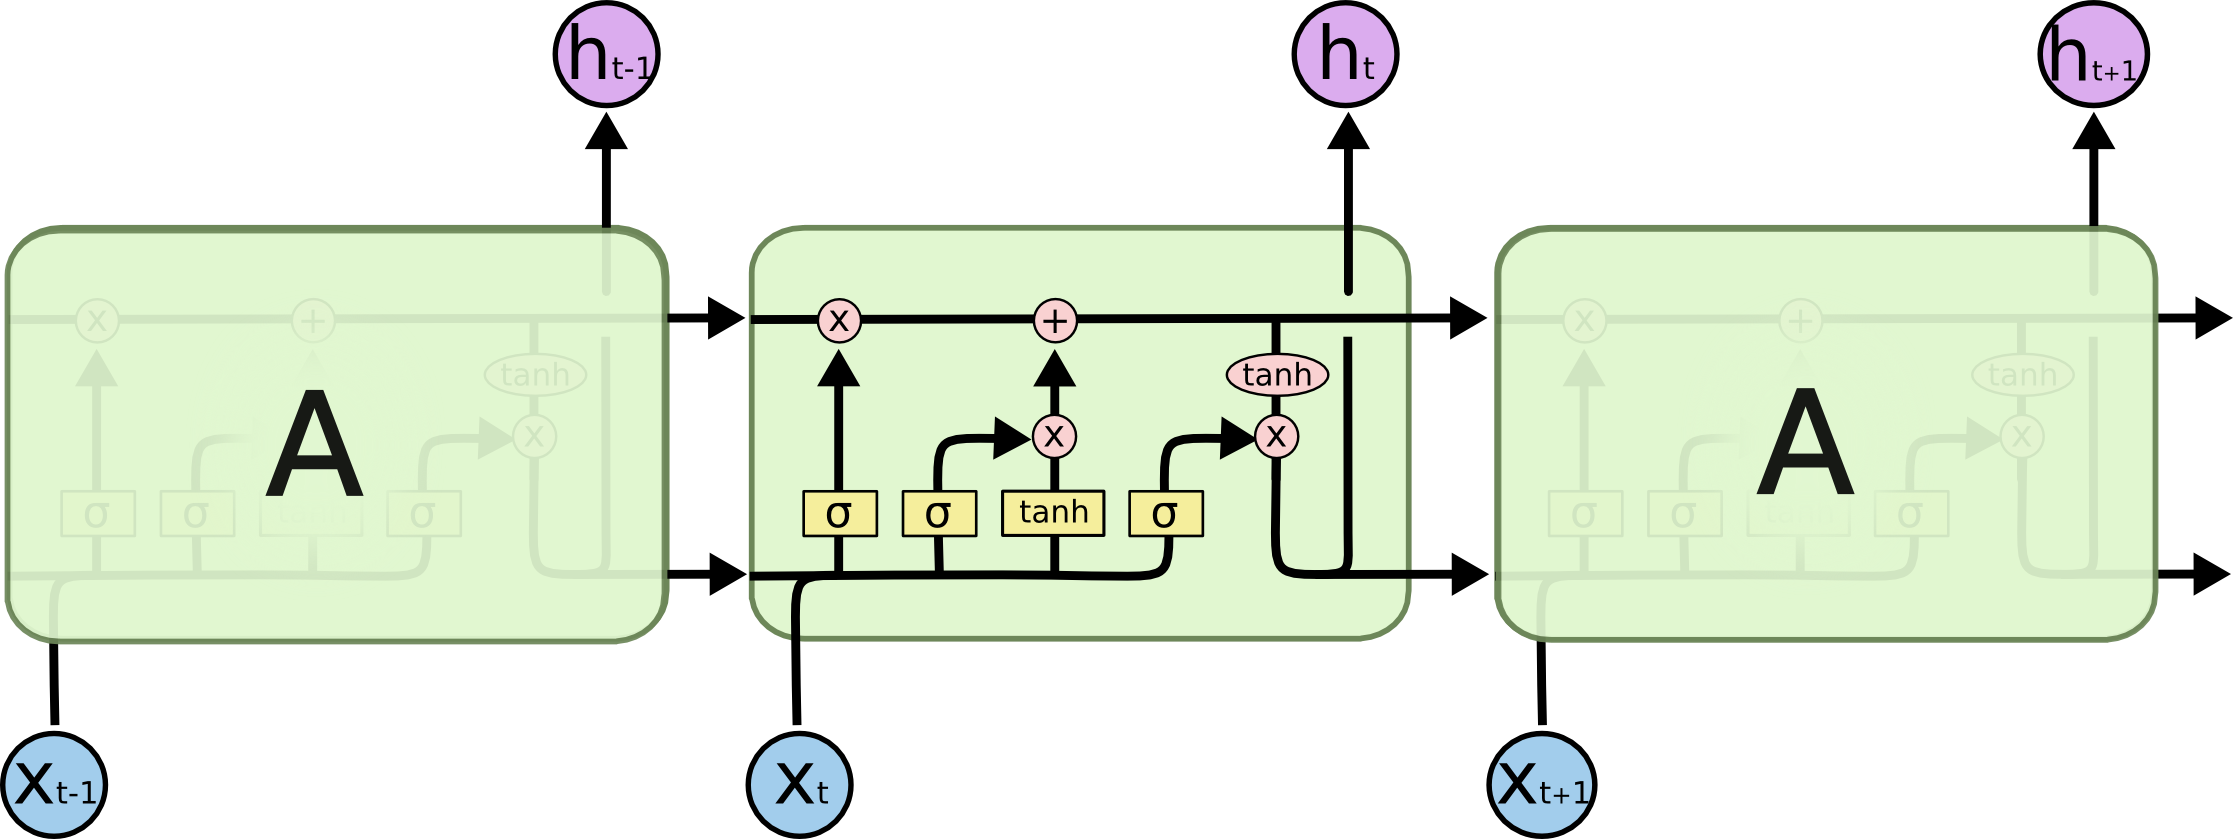

##### Cell State

셀 상태는 장기기억을 담당하는 부분으로 $\times$로 기존 정보를 얼마나 남길 것인지 비중을 곱하고 이번 입력의 정보를 더함
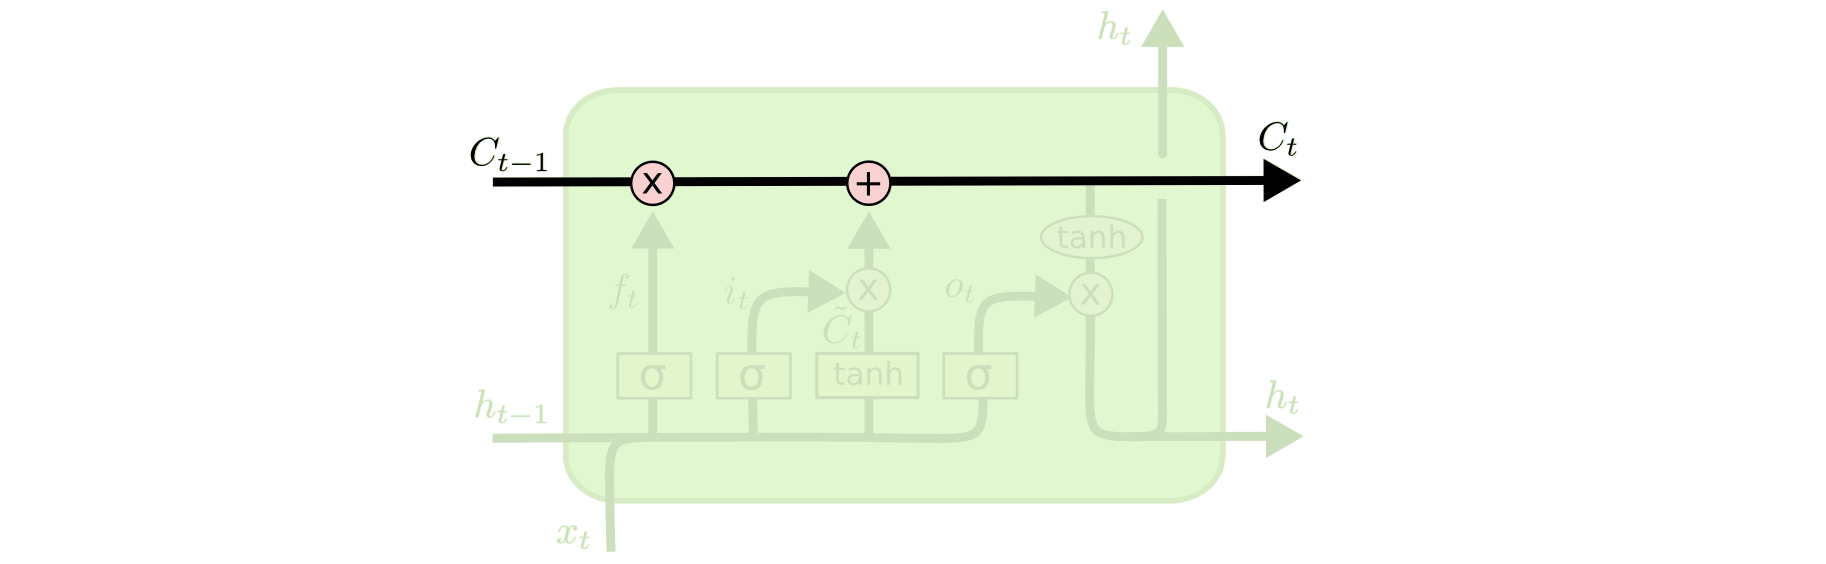

##### Forget Gate (망각 게이트)

기존 정보들로 구성된 셀 상태의 값을 얼마나 잊어버릴지 정하는 단계 : 가중치를 곱하고 편향을 더해 시그모이드로 결정

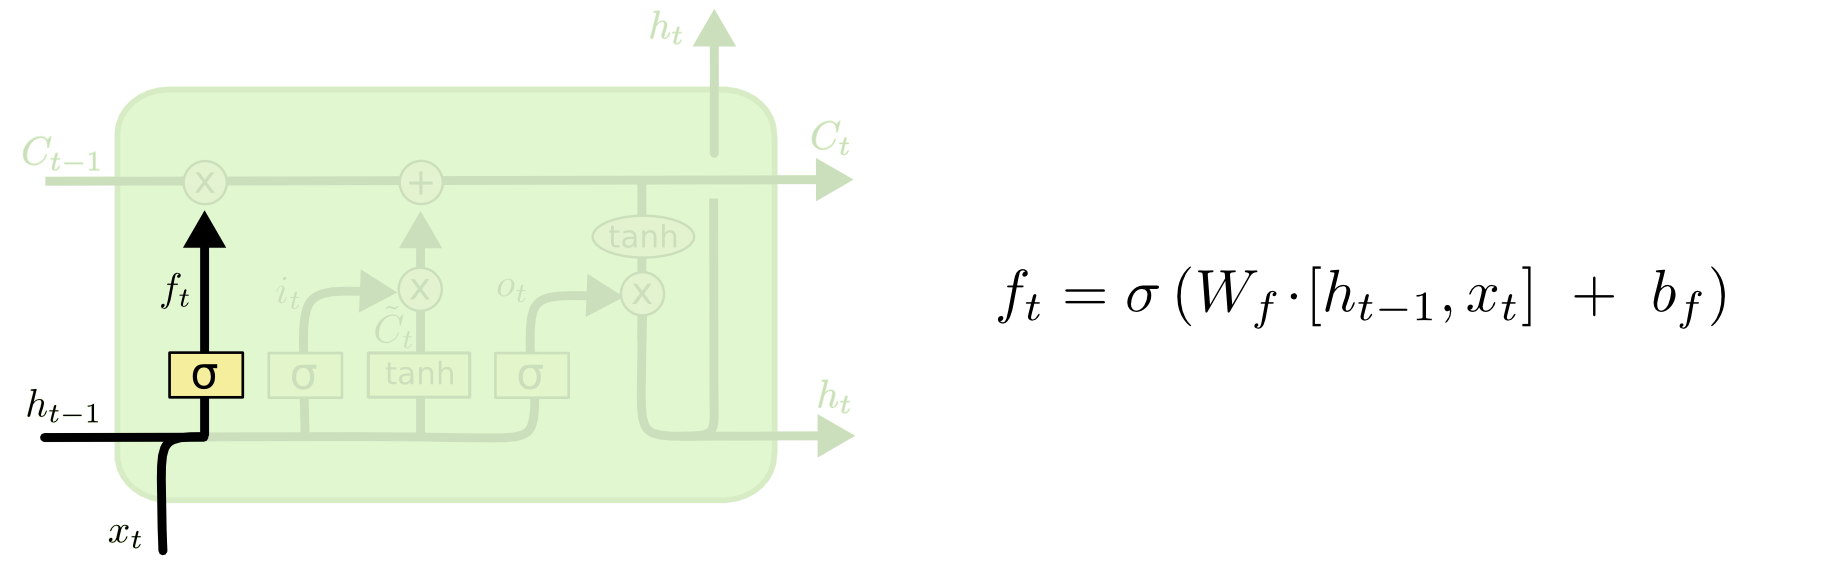

##### 입력 게이트 (Input Gate)

어떤 정보를 얼마나 셀 상태에 저장할지 정하는 부분

tanh : -1 ~ 1의 값, 시그모이드 : 0 ~ 1의 값

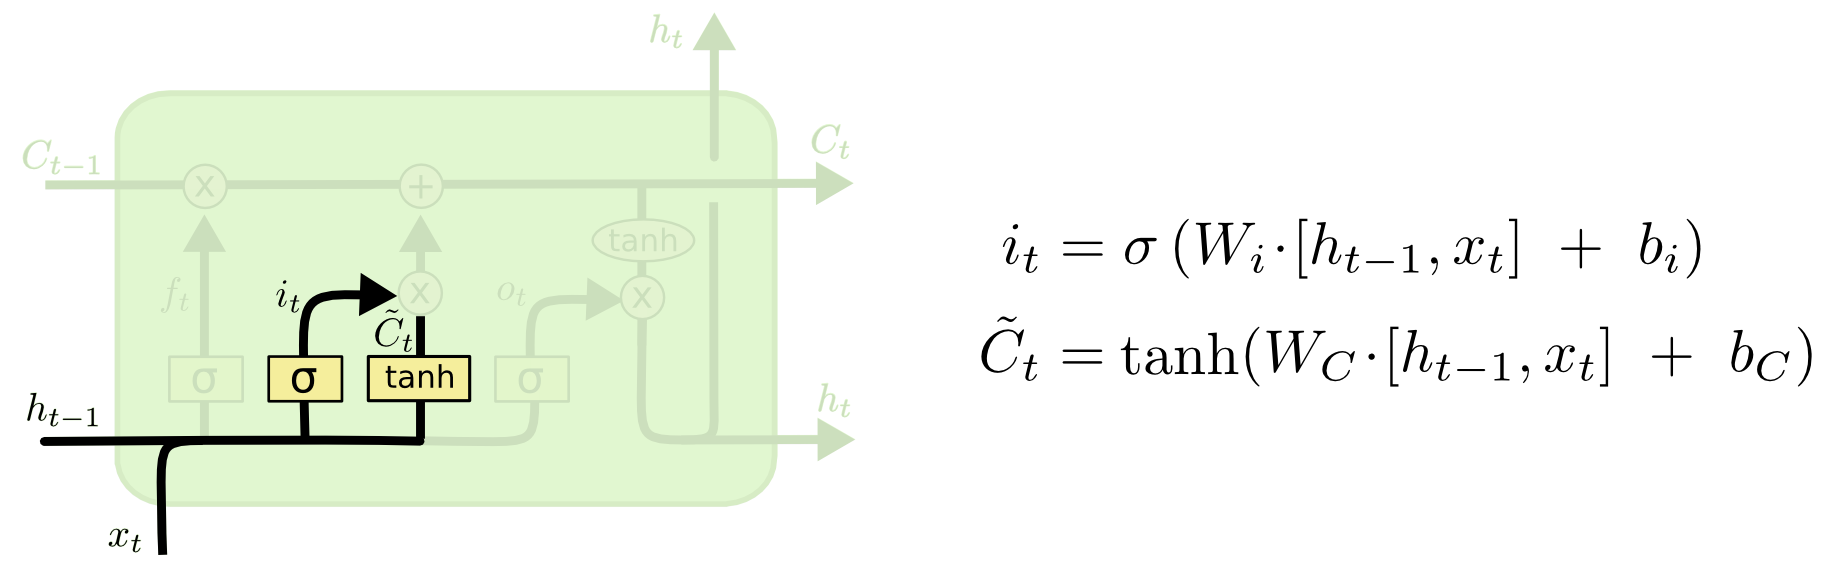

같이 모아보면 
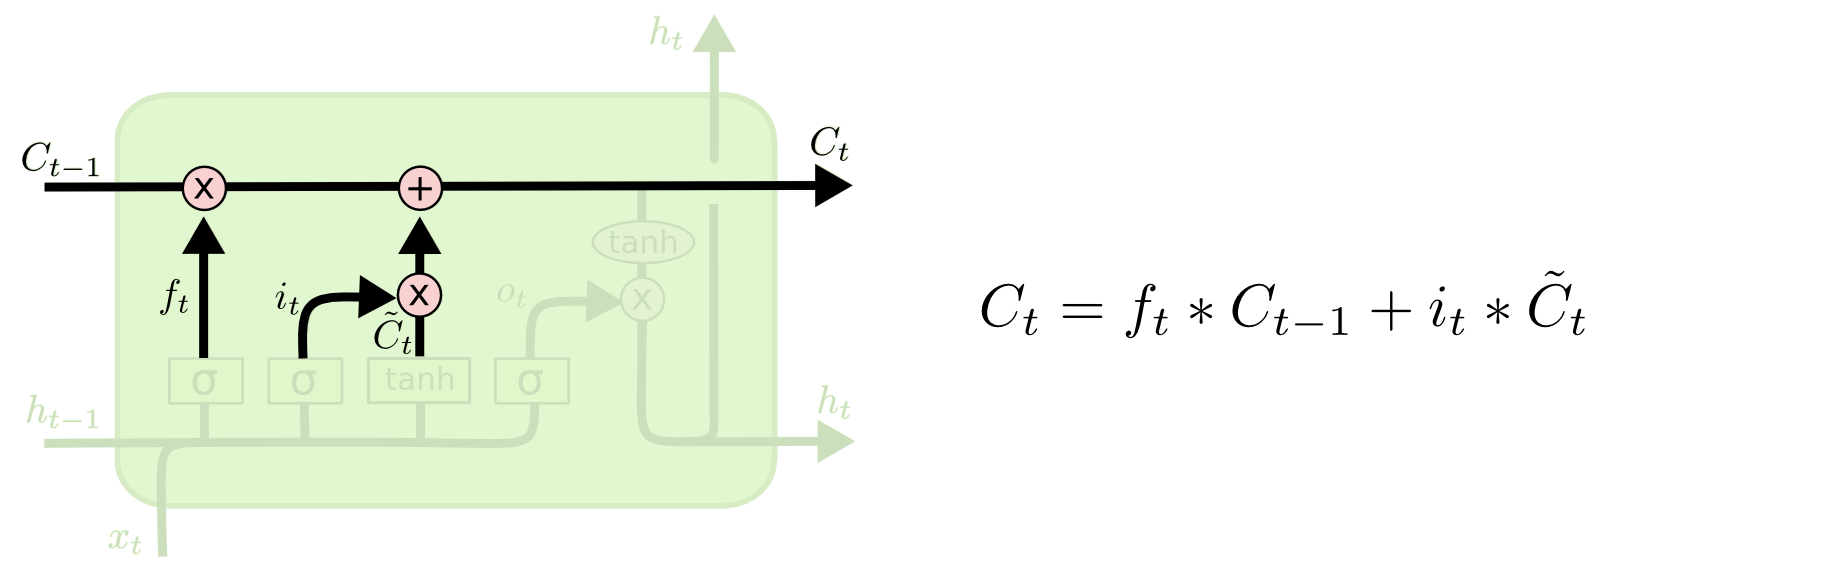

##### Hidden State
시그모이드로 이번 입력으로 계산된 비중을 정하고 현재 cell state를 곱해서 다음 hidden state로 넘김

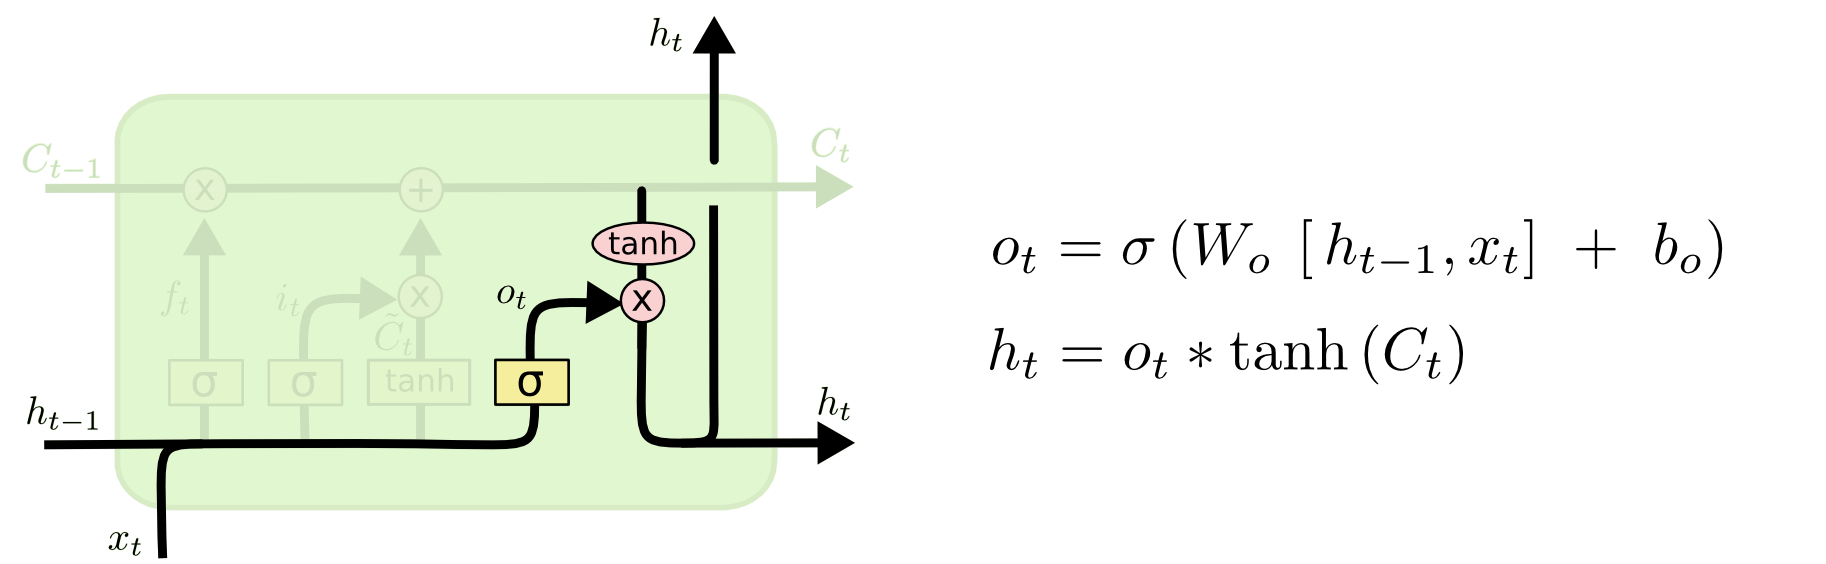

#### GRU
Gated Recurrent Unit 2014 조경현 교수 논문에서 발표했대

LSTM보다 단순 : 셀 상태와 은닉 상태를 분리하지 않고 

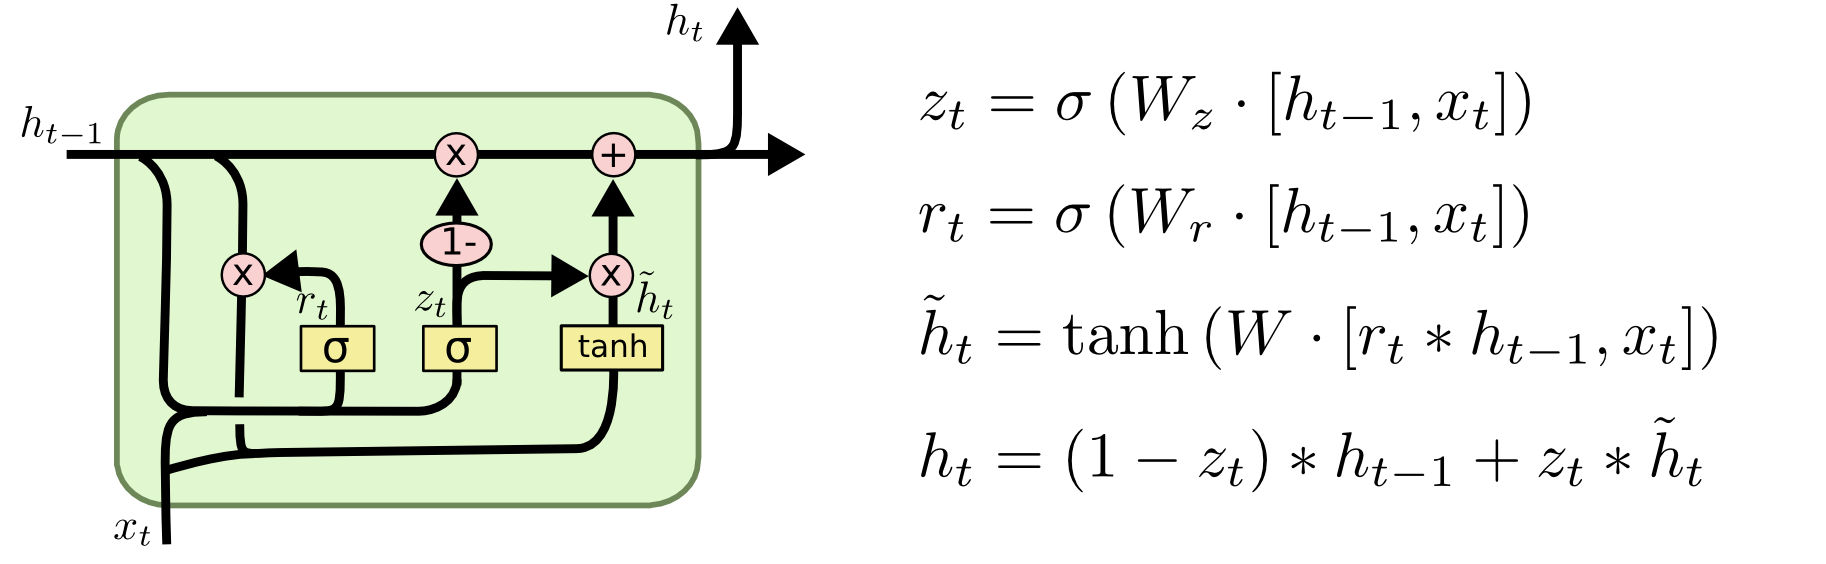